In [1]:
"""
Extract Active Fire Detections (AFDs) from MODIS and VIIRS within "aspen fires"

Author: maxwell.cook@colorado.edu
"""

import os, time, glob, sys
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") # suppresses annoying geopandas warning

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# Load the fire data.

In [3]:
aspen_events_fp = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-ics_2018_to_2023-aspen.gpkg')
aspen_events = gpd.read_file(aspen_events_fp)
aspen_events.columns

Index(['NIFC_ID', 'NIFC_NAME', 'NIFC_ACRES', 'FINAL_ACRES', 'pct_aspen',
       'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'CAUSE', 'DISCOVERY_DATE',
       'DISCOVERY_DOY', 'WF_CESSATION_DATE', 'WF_CESSATION_DOY',
       'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL', 'STR_THREATENED_MAX',
       'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'WF_PEAK_AERIAL',
       'WF_PEAK_PERSONNEL', 'na_l3name', 'geometry'],
      dtype='object')

In [4]:
# Create a fire perimeter buffer to extract FRP observations within 1km of bounds.
bounds = create_bounds(aspen_events, buffer=1000, method='convex_hull')
bounds = bounds.set_crs(proj, allow_override=True) # ensure correct crs
bounds = bounds[['NIFC_ID','NIFC_NAME','START_YEAR','DISCOVERY_DATE','WF_CESSATION_DATE','na_l3name','geometry']] 
bounds['START_YEAR'] = bounds['START_YEAR'].astype(int)
date_cols = ['DISCOVERY_DATE', 'WF_CESSATION_DATE']
for col in date_cols:
    bounds[col] = pd.to_datetime(bounds[col], errors='coerce')
bounds.head()

,NIFC_ID,NIFC_NAME,START_YEAR,DISCOVERY_DATE,WF_CESSATION_DATE,na_l3name,geometry
0,6,DEVIL CREEK,2018,2018-07-19 15:46:00,2018-07-21 15:00:00,Southern Rockies,"POLYGON ((-981652.207 1644806.151, -981706.081..."
1,8,577,2019,2019-07-28 14:22:00,2019-08-18 16:00:00,Southern Rockies,"POLYGON ((-1003686.183 1627306.363, -1003781.1..."
2,14,416,2018,2018-06-01 11:02:00,2018-07-03 18:00:00,Southern Rockies,"POLYGON ((-1038873.972 1658050.554, -1038972.9..."
3,23,LOADING PEN,2020,2020-06-13 21:42:00,2020-06-18 17:45:00,Southern Rockies,"POLYGON ((-1071536.445 1681756.498, -1071604.3..."
4,24,PLATEAU,2018,2018-07-22 16:18:00,2018-08-17 18:45:00,Southern Rockies,"POLYGON ((-1092835.850 1682570.218, -1092883.9..."


In [5]:
bounds.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Load the Active Fire Detections (AFD) [2018-2023]
AFDs from MODIS Collection 6.1 (1km) and the Suomi National Polar-Orbiting Partnership (VIIRS S-NPP 375m) were obtained from the NASA FIRMS (https://firms.modaps.eosdis.nasa.gov/download/) between 2018-2023 in the western US. The S-NPP AFDs include an archive shapefile and a NRT shapefile for Sept 2022-->

In [6]:
# Gather the archive and NRT S-NPP AFDs.
snpp_fp = os.path.join(projdir,'data/spatial/raw/NASA-FIRMS/y2018_to_2023/DL_FIRE_SV-C2_476784/')
vects = glob.glob(snpp_fp+"*.shp")
print([os.path.basename(v) for v in vects])

['fire_nrt_SV-C2_476784.shp', 'fire_archive_SV-C2_476784.shp']


In [7]:
# Merge the NRT and archive vintages
archive = gpd.read_file([v for v in vects if "archive" in v][0]).to_crs(proj)
nrt = gpd.read_file([v for v in vects if "nrt" in v][0]).to_crs(proj)
snpp = pd.concat([archive, nrt], ignore_index=True)
snpp.head()

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry
0,36.622398,-119.958420,319.25,0.45,0.63,2018-01-01,0854,N,VIIRS,n,1,276.46,1.93,N,0.0,POINT (-2100437.814 1774627.392)
1,48.166241,-102.698212,323.92,0.38,0.36,2018-01-01,0854,N,VIIRS,n,1,244.01,3.01,N,0.0,POINT (-502299.189 2814197.682)
2,48.152390,-102.697792,325.34,0.38,0.36,2018-01-01,0854,N,VIIRS,n,1,247.16,2.07,N,0.0,POINT (-502375.241 2812672.753)
3,47.879730,-102.706543,320.74,0.38,0.36,2018-01-01,0854,N,VIIRS,n,1,245.34,3.00,N,0.0,POINT (-505150.481 2782728.231)
4,44.249660,-104.516678,327.49,0.38,0.36,2018-01-01,0854,N,VIIRS,n,1,251.79,5.84,N,0.0,POINT (-677212.174 2392519.636)


In [8]:
# Set up a dictionary to store both MODIS and VIIRS AFDs
modis_fp = os.path.join(projdir,'data/spatial/raw/NASA-FIRMS/y2018_to_2023/DL_FIRE_M-C61_476781/')

# Store these in a dictionary
afds = {
    "MOD61": gpd.read_file(modis_fp).to_crs(proj),
    "SNPP": snpp
}

afds['MOD61'].head()

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry
0,44.3762,-119.1190,312.5,1.2,1.1,2018-01-01,0608,Terra,MODIS,85,6.03,269.1,21.9,N,0,POINT (-1819292.701 2598646.798)
1,32.1679,-107.7655,322.3,1.1,1.0,2018-01-01,1809,Terra,MODIS,77,6.03,289.1,19.0,D,0,POINT (-1101321.656 1078752.715)
2,32.1643,-107.7433,318.4,1.1,1.0,2018-01-01,1809,Terra,MODIS,74,6.03,287.9,14.9,D,0,POINT (-1099303.652 1078097.526)
3,31.7188,-102.0085,303.8,1.4,1.2,2018-01-01,1944,Aqua,MODIS,57,6.03,279.4,12.6,D,0,POINT (-566656.554 978378.293)
4,38.8238,-122.6829,302.0,2.7,1.6,2018-01-01,1946,Terra,MODIS,50,6.03,280.2,26.9,D,0,POINT (-2264952.497 2075236.763)


In [9]:
afds['MOD61'].crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [10]:
# Extract the AFDs within fire bounds.

In [11]:
afd_events = {} # to store the filtered data
duplicate_list = [] # to store duplicate obs.
# Loop through sensors (MODIS and VIIRS)
for satellite, afd in afds.items():
    print(f"Processing: {satellite}")
    
    afd['VID'] = afd.index # add a unique ID

    # ####################################
    # # Remove low confidence observations
    # try:
    #     afd = afd[afd['CONFIDENCE'] != 'l']
    # except KeyError as e:
    #     print(f"KeyError: {e}")

    ############################
    # Extract within fire bounds
    if afd.crs != bounds.crs:
        afd = afd.to_crs(bounds.crs)  # ensure the crs matches

    afd_ = gpd.sjoin(afd, bounds, how='inner', predicate='within')
    afd_.drop(columns=['index_right'], inplace=True)

    ####################################
    # Tidy the date columns for matching
    afd_['ACQ_DATE'] = pd.to_datetime(afd_['ACQ_DATE'])
    afd_['ACQ_MONTH'] = afd_['ACQ_DATE'].dt.month.astype(int)
    afd_['ACQ_YEAR'] = afd_['ACQ_DATE'].dt.year.astype(int)
    
    # Create a datetime object
    afd_.loc[:, 'ACQ_DATETIME'] = afd_.apply(lambda row: convert_datetime(row['ACQ_DATE'], row['ACQ_TIME']), axis=1)
    
    # Filter for matching dates
    afd_f = afd_[
        (afd_['ACQ_YEAR'] >= afd_['DISCOVERY_DATE'].dt.year.astype(int)) & 
        (afd_['ACQ_MONTH'] >= afd_['DISCOVERY_DATE'].dt.month.astype(int)) &
        (afd_['ACQ_YEAR'] <= afd_['WF_CESSATION_DATE'].dt.year.astype(int)) &
        (afd_['ACQ_MONTH'] <= afd_['WF_CESSATION_DATE'].dt.month.astype(int))
    ]

    #####################
    # Drop any duplicates
    duplicates = afd_f[afd_f.duplicated(subset='VID', keep=False)]
    if len(duplicates) > 0:
        print(f"Be aware ! Duplicates found ! {len(duplicates)} to be exact ...")
        duplicate_list.append(duplicates)
        afd_f = afd_f.drop_duplicates(subset='VID', keep='first')

    ######################
    
    print(f"\tThere are [{len(afd_f)}] high or nominal confidence detections within fire bounds.")

    # Overwrite the dictionary items
    afd_events[satellite] = afd_f

    # Save the AFD observation in fire bounds
    out_fp = os.path.join(projdir,f'data/spatial/mod/AFD/{satellite}/{satellite}-afd_aspen-fires_2018_to_2023.gpkg')
    afd_f.to_file(out_fp)
    print(f'Saved to {out_fp}\n')
    
    del afd, afd_, afd_f, duplicates
    gc.collect()

# Export duplicates if they exist
if duplicate_list:
    duplicates_gdf = pd.concat(duplicate_list, ignore_index=True)
    out_fp = os.path.join(projdir, 'data/spatial/mod/AFD/afd_duplicates.gpkg')
    duplicates_gdf.to_file(out_fp)
    print(f"Saved duplicates to {out_fp}")
    
print("\nProcessing complete !")

Processing: MOD61
Be aware ! Duplicates found ! 348 to be exact ...
	There are [27978] high or nominal confidence detections within fire bounds.
Saved to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/AFD/MOD61/MOD61-afd_aspen-fires_2018_to_2023.gpkg

Processing: SNPP
Be aware ! Duplicates found ! 1250 to be exact ...
	There are [116986] high or nominal confidence detections within fire bounds.
Saved to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/AFD/SNPP/SNPP-afd_aspen-fires_2018_to_2023.gpkg

Saved duplicates to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/AFD/afd_duplicates.gpkg

Processing complete !


In [12]:
afd_events['MOD61'].columns

Index(['LATITUDE', 'LONGITUDE', 'BRIGHTNESS', 'SCAN', 'TRACK', 'ACQ_DATE',
       'ACQ_TIME', 'SATELLITE', 'INSTRUMENT', 'CONFIDENCE', 'VERSION',
       'BRIGHT_T31', 'FRP', 'DAYNIGHT', 'TYPE', 'geometry', 'VID', 'NIFC_ID',
       'NIFC_NAME', 'START_YEAR', 'DISCOVERY_DATE', 'WF_CESSATION_DATE',
       'na_l3name', 'ACQ_MONTH', 'ACQ_YEAR', 'ACQ_DATETIME'],
      dtype='object')

In [13]:
# Create the AFD "detection buffer" for both MODIS and VIIRS

In [14]:
afd_events_plots = {} # to store the buffered observations
for satellite, afd in afd_events.items():
    print(f"Creating buffer for {satellite} observations.")

    afd_ = afd.copy()
    if satellite == 'MOD61':
        afd_.geometry = afd_.geometry.buffer(500, cap_style=3) # square buffer half of pixel size
    elif satellite == 'SNPP':
        afd_.geometry = afd_.geometry.buffer(187.5, cap_style=3) # square buffer half of pixel size

    afd_events_plots[satellite] = afd_ # add to the new dictionary

    # Save out
    out_fp = os.path.join(projdir,f'data/spatial/mod/AFD/{satellite}-afd_aspen-fires_2018_to_2023_buffer.gpkg')
    afd_.to_file(out_fp)
    print(f'Saved to {out_fp}\n')

    del afd_
    gc.collect()

Creating buffer for MOD61 observations.
Saved to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/AFD/MOD61-afd_aspen-fires_2018_to_2023_buffer.gpkg

Creating buffer for SNPP observations.
Saved to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/AFD/SNPP-afd_aspen-fires_2018_to_2023_buffer.gpkg



In [15]:
print(afd_events_plots['MOD61'].columns)
print("\n~~~~~~~~~\n")
print(afd_events_plots['SNPP'].columns)

Index(['LATITUDE', 'LONGITUDE', 'BRIGHTNESS', 'SCAN', 'TRACK', 'ACQ_DATE',
       'ACQ_TIME', 'SATELLITE', 'INSTRUMENT', 'CONFIDENCE', 'VERSION',
       'BRIGHT_T31', 'FRP', 'DAYNIGHT', 'TYPE', 'geometry', 'VID', 'NIFC_ID',
       'NIFC_NAME', 'START_YEAR', 'DISCOVERY_DATE', 'WF_CESSATION_DATE',
       'na_l3name', 'ACQ_MONTH', 'ACQ_YEAR', 'ACQ_DATETIME'],
      dtype='object')

~~~~~~~~~

Index(['LATITUDE', 'LONGITUDE', 'BRIGHTNESS', 'SCAN', 'TRACK', 'ACQ_DATE',
       'ACQ_TIME', 'SATELLITE', 'INSTRUMENT', 'CONFIDENCE', 'VERSION',
       'BRIGHT_T31', 'FRP', 'DAYNIGHT', 'TYPE', 'geometry', 'VID', 'NIFC_ID',
       'NIFC_NAME', 'START_YEAR', 'DISCOVERY_DATE', 'WF_CESSATION_DATE',
       'na_l3name', 'ACQ_MONTH', 'ACQ_YEAR', 'ACQ_DATETIME'],
      dtype='object')


In [16]:
# Combine the MODIS and VIIRS buffers into a single GeoDataFrame
afd_events_plots_c = pd.concat([afd_events_plots['MOD61'], afd_events_plots['SNPP']], ignore_index=True)
# Create a new identifier
afd_events_plots_c['afdID'] = afd_events_plots_c['INSTRUMENT'].astype(str) + afd_events_plots_c['VID'].astype(str)
afd_events_plots_c[['NIFC_ID','NIFC_NAME','afdID']].head()

,NIFC_ID,NIFC_NAME,afdID
0,9582,SAULS,MODIS7298
1,9582,SAULS,MODIS7301
2,69318,PINE RIDGE,MODIS7989
3,69318,PINE RIDGE,MODIS7990
4,69318,PINE RIDGE,MODIS7991


In [17]:
# Check on the number of observations per fire/sensor
afd_counts = afd_events_plots_c.groupby(['NIFC_ID','INSTRUMENT']).size().reset_index(name='counts')
print(afd_counts.head(10))
print(f"Minimum obs./fire: {afd_counts['counts'].min()}; \nMaximum obs./fire: {afd_counts['counts'].max()}")

  NIFC_ID INSTRUMENT  counts
0  100763      MODIS       4
1  100763      VIIRS      16
2    1055      MODIS      16
3    1055      VIIRS      52
4    1070      MODIS    1227
5    1070      VIIRS    4997
6   12229      MODIS      24
7   12229      VIIRS     152
8   13137      MODIS       4
9   13137      VIIRS       3
Minimum obs./fire: 1; 
Maximum obs./fire: 12563


In [18]:
# Only keep events with > X observations from either instrument

print(f"Number of AFDs before filtering: {len(afd_events_plots_c)}")

# Get a list of IDs of fires with > 1 obs.
ids = afd_counts[afd_counts["counts"] > 1]
# Grab the new list of unique FIRED ids
ids = ids['NIFC_ID'].unique().tolist()

# Keep only fires with greater than 1 obs.
afd_events_plots_c = afd_events_plots_c[afd_events_plots_c['NIFC_ID'].isin(ids)]

print(f"Number of AFDs after filtering: {len(afd_events_plots_c)}")

Number of AFDs before filtering: 144964
Number of AFDs after filtering: 144954


In [19]:
# Export to file.
out_fp = os.path.join(projdir,f'data/spatial/mod/AFD/combined-afd_aspen-fires_2018_to_2023_buffer.gpkg')
afd_events_plots_c.to_file(out_fp)
print(f'Saved to {out_fp}\n')

Saved to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/AFD/combined-afd_aspen-fires_2018_to_2023_buffer.gpkg



In [20]:
print(len(afd_events_plots_c['NIFC_ID'].unique()))

173


In [22]:
# Save out the fires in southern rockies with > 10 AFD
fires = afd_counts[afd_counts['counts'] > 10]
aspen_events_srm = aspen_events[aspen_events['na_l3name'] == 'Southern Rockies']
aspen_events_srm = aspen_events_srm[aspen_events_srm['NIFC_ID'].isin(fires['NIFC_ID'].unique())]
aspen_events_srm.head()

,NIFC_ID,NIFC_NAME,NIFC_ACRES,FINAL_ACRES,pct_aspen,INCIDENT_ID,INCIDENT_NAME,START_YEAR,CAUSE,DISCOVERY_DATE,...,WF_CESSATION_DOY,STR_DESTROYED_TOTAL,STR_DAMAGED_TOTAL,STR_THREATENED_MAX,EVACUATION_REPORTED,PEAK_EVACUATIONS,WF_PEAK_AERIAL,WF_PEAK_PERSONNEL,na_l3name,geometry
2,14,416,54130.98,54129,38.614463,2018_9091030_416,416,2018,U,2018-06-01 11:02:00,...,184,0,0,3386,1,2182,15,429.125,Southern Rockies,"MULTIPOLYGON (((-1047907.942 1672642.863, -104..."
4,24,PLATEAU,19677.32,19634,1.305924,2018_9223810_PLATEAU,PLATEAU,2018,L,2018-07-22 16:18:00,...,229,0,0,NaN,NaN,NaN,4,143.6,Southern Rockies,"POLYGON ((-1094448.086 1686999.388, -1094448.7..."
5,26,PLUMTAW,721.4,721,70.241348,2022_14542839_PLUMTAW,PLUMTAW,2022,U,2022-05-17 13:49:00,...,138,0,0,75,1,200,4.5,242.6666666666666,Southern Rockies,"POLYGON ((-969787.326 1648469.699, -969792.261..."
6,33,DOE CANYON,2559.52,2560,8.358058,2019_10738675_DOE CANYON,DOE CANYON,2019,L,2019-06-20 14:41:00,...,184,0,0,NaN,NaN,NaN,NaN,44,Southern Rockies,"POLYGON ((-1104275.303 1705190.773, -1104275.0..."
7,43,CHRIS MOUNTAIN,510.51,511,1.574569,2023_15990891_CHRIS MOUNTAIN,CHRIS MOUNTAIN,2023,L,2023-06-28 15:57:00,...,185,0,0,7,1,2,7,293.1785714285714,Southern Rockies,"POLYGON ((-984454.113 1641237.622, -984454.991..."


In [23]:
len(aspen_events_srm)

49

In [24]:
out_fp = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-ics_2018_to_2023-aspen_SRM.gpkg')
aspen_events_srm.to_file(out_fp)
print(f"Saved to: {out_fp}")

Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/NIFC/nifc-ics_2018_to_2023-aspen_SRM.gpkg


In [21]:
# Gather bounds for individual fires/AFDs for both instruments.

In [22]:
buffer = 1000 # meters
# Group by fire ID
grouped = afd_events_plots_c.groupby('NIFC_ID')
bounds_gdf = gpd.GeoDataFrame(columns=['NIFC_ID', 'geometry'], crs=afd.crs)
# Iterate over each fire group
for fire_id, group in grouped:
    # Calculate the total bounds (minx, miny, maxx, maxy) for all geometries in the group
    bounds = box(*group.total_bounds)
    # Apply buffer if specified
    if buffer is not None:
        bounds = bounds.buffer(buffer)
    # Create a GeoDataFrame for this fire with the bounding box, id, and ig_year
    fire_gdf = gpd.GeoDataFrame({'NIFC_ID': [fire_id], 'geometry': [bounds]}, crs=afd.crs)
    # Append the result to the GeoDataFrame
    bounds_gdf = pd.concat([bounds_gdf, fire_gdf], ignore_index=True)

# Dissolve by NIFC_ID
afd_fire_bounds = bounds_gdf.dissolve(by='NIFC_ID')
afd_fire_bounds = pd.merge(afd_fire_bounds, aspen_events.drop(columns=['geometry']), left_on='NIFC_ID', right_on='NIFC_ID', how='left')
print(len(afd_fire_bounds['NIFC_ID'].unique()))
print(afd_fire_bounds.columns)

173
Index(['NIFC_ID', 'geometry', 'NIFC_NAME', 'NIFC_ACRES', 'FINAL_ACRES',
       'pct_aspen', 'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'CAUSE',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'WF_CESSATION_DATE',
       'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL',
       'STR_THREATENED_MAX', 'EVACUATION_REPORTED', 'PEAK_EVACUATIONS',
       'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 'na_l3name'],
      dtype='object')


In [23]:
# Make some plots.

In [24]:
afd_events_plots_c['INSTRUMENT'].unique()

array(['MODIS', 'VIIRS'], dtype=object)

<Figure size 800x600 with 0 Axes>

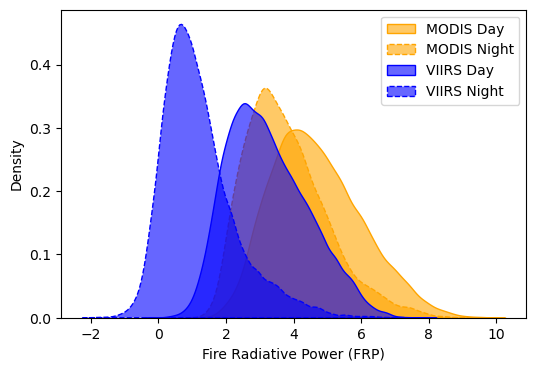

In [25]:
# Day/Night FRP

plt.figure(figsize=(8, 6))

df = afd_events_plots_c.copy() # make a copy for plotting

# Filter day and night observations for MODIS and VIIRS
modis_day = df[(df['DAYNIGHT'] == 'D') & (df['INSTRUMENT'] == 'MODIS')]['FRP']
modis_night = df[(df['DAYNIGHT'] == 'N') & (df['INSTRUMENT'] == 'MODIS')]['FRP']
viirs_day = df[(df['DAYNIGHT'] == 'D') & (df['INSTRUMENT'] == 'VIIRS')]['FRP']
viirs_night = df[(df['DAYNIGHT'] == 'N') & (df['INSTRUMENT'] == 'VIIRS')]['FRP']

# Log scale for each subset
modis_day_log = np.log(modis_day[modis_day > 0])
modis_night_log = np.log(modis_night[modis_night > 0])
viirs_day_log = np.log(viirs_day[viirs_day > 0])
viirs_night_log = np.log(viirs_night[viirs_night > 0])

# Show the distribution of FRP values for day and night observations
plt.figure(figsize=(6, 4))

# Plotting the KDE
sns.kdeplot(modis_day_log, fill=True, color="orange", label="MODIS Day", alpha=0.6)
sns.kdeplot(modis_night_log, fill=True, color="orange", linestyle='--', label="MODIS Night", alpha=0.6)
sns.kdeplot(viirs_day_log, fill=True, color="blue", label="VIIRS Day", alpha=0.6)
sns.kdeplot(viirs_night_log, fill=True, color="blue", linestyle='--', label="VIIRS Night", alpha=0.6)

# Adding labels and title
plt.xlabel('Fire Radiative Power (FRP)')
plt.ylabel('Density')
plt.legend()

plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_frp_density_day-night.png'), dpi=300, bbox_inches='tight')

plt.show()

In [26]:
# Join to state boundaries, assign "Start_Day" and "End_Day" from Parks et al. (2019)

In [27]:
states = os.path.join(maindir, 'data/boundaries/political/TIGER/tl19_us_states_w_ak_lambert.gpkg')
states = gpd.read_file(states)
states = states.to_crs(proj)
states.columns

Index(['REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'STUSPS', 'NAME',
       'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry'],
      dtype='object')

In [28]:
centroid = afd_fire_bounds.copy()
centroid['geometry'] = centroid.geometry.centroid
fire_state = gpd.overlay(centroid[['NIFC_ID','geometry']], states[['STUSPS','geometry']], how='intersection')
fire_state = fire_state[['NIFC_ID','STUSPS']]
afd_fire_bounds_ = pd.merge(afd_fire_bounds, fire_state, on='NIFC_ID', how='left')
afd_fire_bounds_.columns

Index(['NIFC_ID', 'geometry', 'NIFC_NAME', 'NIFC_ACRES', 'FINAL_ACRES',
       'pct_aspen', 'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'CAUSE',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'WF_CESSATION_DATE',
       'WF_CESSATION_DOY', 'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL',
       'STR_THREATENED_MAX', 'EVACUATION_REPORTED', 'PEAK_EVACUATIONS',
       'WF_PEAK_AERIAL', 'WF_PEAK_PERSONNEL', 'na_l3name', 'STUSPS'],
      dtype='object')

In [29]:
len(afd_fire_bounds_[afd_fire_bounds_['na_l3name'] == 'Southern Rockies'])

61

In [30]:
# Assign the Parks et al. (2019) start and end days
special_case = ['Arizona', 'New Mexico']
afd_fire_bounds_['Start_Day'] = None
afd_fire_bounds_['End_Day'] = None    

afd_fire_bounds_.loc[afd_fire_bounds_['STUSPS'].isin(special_case), ['Start_Day', 'End_Day']] = (91, 181)
afd_fire_bounds_.loc[~afd_fire_bounds_['STUSPS'].isin(special_case), ['Start_Day', 'End_Day']] = (152, 258)

afd_fire_bounds_ = afd_fire_bounds_[['NIFC_ID','NIFC_NAME','DISCOVERY_DOY','WF_CESSATION_DOY','START_YEAR','Start_Day','End_Day','geometry']]
afd_fire_bounds_ = afd_fire_bounds_.rename(columns={
    'NIFC_ID': 'Fire_ID', 
    'NIFC_NAME': 'Fire_Name',
    'START_YEAR': 'Fire_Year'
})
afd_fire_bounds_.head()

,Fire_ID,Fire_Name,DISCOVERY_DOY,WF_CESSATION_DOY,Fire_Year,Start_Day,End_Day,geometry
0,100763,PARK CREEK,272,286,2022,152,258,"POLYGON ((-1302777.051 2935597.721, -1304470.8..."
1,1055,RATTLESNAKE,232,236,2020,152,258,"POLYGON ((-1662672.883 2765896.178, -1665553.8..."
2,1070,GREEN RIDGE,188,250,2021,152,258,"POLYGON ((-1648322.560 2755617.377, -1673173.6..."
3,12229,SCHAEFFER,251,272,2019,152,258,"POLYGON ((-1978906.428 1675019.040, -1982045.2..."
4,13137,COUGAR,305,315,2020,152,258,"POLYGON ((-1587662.179 2645713.160, -1590213.9..."


In [31]:
# Save out the bounds to a file for GEE.
out_fp = os.path.join(projdir, f'data/earth-engine/imports/afd_aspen-fires_2018_to_2023_bounds.shp')
afd_fire_bounds_.to_file(out_fp)
print(f"Saved to {out_fp}\n")

Saved to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/earth-engine/imports/afd_aspen-fires_2018_to_2023_bounds.shp



In [32]:
gc.collect()

0

### Create a time-series product for GRIDMET

This needs to be a daily polygon that can be used to summarize gridmet variables for each observation. For now, taking the union of each daily FRP observation should do the trick.

In [43]:
# Create an acquisition Day of Year
afd_events_plots_c['ACQ_DOY'] = afd_events_plots_c['ACQ_DATETIME'].dt.dayofyear

# Group the AFDs by fire ID and acquisition date
daily_polygons = [] # to store the daily polygons
for (fire_id, year, doy), group in afd_events_plots_c.groupby(['NIFC_ID', 'START_YEAR', 'ACQ_DOY']):
    # Get the geometry of the group (polygons)
    polygons = group.geometry
    # Create a union of the polygons for the day
    if len(polygons) > 1:
        union_polygon = polygons.unary_union  # Union of all polygons
    else:
        union_polygon = polygons.iloc[0]  # If only one polygon, just use it
    
    # Create a GeoDataFrame row for the union polygon
    daily_polygons.append({
        'NIFC_ID': fire_id,
        'FIRE_YEAR': year,
        'ACQ_DOY': doy,
        'geometry': union_polygon
    })

# Convert the list of dictionaries to a GeoDataFrame
daily_polygons_gdf = gpd.GeoDataFrame(daily_polygons, crs=afd_events_plots_c.crs)

out_fp = os.path.join(projdir, f'data/earth-engine/imports/afd_aspen-fires_2018_to_2023_bounds_daily.shp')
daily_polygons_gdf.to_file(out_fp)
print(f"Saved daily polygons to {out_fp}")

Saved daily polygons to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/earth-engine/imports/afd_aspen-fires_2018_to_2023_bounds_daily.shp


In [44]:
daily_polygons_gdf.head()

,NIFC_ID,FIRE_YEAR,ACQ_DOY,geometry
0,100763,2022,278,"POLYGON ((-1302924.731 2938127.779, -1302924.7..."
1,100763,2022,279,"POLYGON ((-1304119.767 2936849.317, -1304119.7..."
2,100763,2022,280,"POLYGON ((-1303310.031 2937490.782, -1303685.0..."
3,100763,2022,281,"POLYGON ((-1303467.796 2938138.289, -1303467.7..."
4,100763,2022,282,"POLYGON ((-1303703.880 2937442.765, -1303703.8..."
